In [1]:
import uproot 
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
import mplhep as hep
import awkward as ak
import pandas as pd
import numpy as np
import sys,os
import yaml

In [2]:
import seaborn as sns
def set_sns_color(*args):
    sns.palplot(sns.color_palette(*args))
    sns.set_palette(*args)
    
color_order_bkg = sns.color_palette('Accent', 3)
color_order_bkg.reverse()

In [3]:
use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [4]:
sys.path.append("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/lib")
from utils import *

In [5]:
config = {}
with open("/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/config_UL16.yml") as f:
    config = yaml.safe_load(f)
config.keys()

sf_particleNet_signal = {}
with open('/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/cards/NetSF_signal_2016Legacy.yml') as f:
    sf_particleNet_signal = yaml.safe_load(f)

In [6]:
year = '2016'

In [7]:
def extractBranch(config):
    r'''
    '''
    bkg_array = {}
    data_array = None
    signal_array = {}
    sumWeight = {}
    for sample in config['Samples_lists']:
        print(f"This is {sample}")
        if sample!='Data':
            indir = config['ori_dir']+config['samples_inf'][sample][0]+'/skimed'
            files = find_this_rootfiles(indir)
            sumWeight[sample] = 0

            for file in files:
                with uproot.open(f'{indir}/{file}') as f:
                    this_sumWeight_h = f['sumWeights'].to_boost()
                    this_sumWeight = this_sumWeight_h.sum()
                    #print(f'this sum weight = {this_sumWeight}')
                    sumWeight[sample] += this_sumWeight

            bkg_array[sample] = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=config['var_read_lists'])

        else:
            data_path = config['ori_dir']+config['samples_inf']['Data'][0]
            data_array = uproot.lazy([f"{data_path}:passedEvents"],filter_name=config['var_read_lists'])

    for sample in config['signal_lists']:
        print(f"This is {sample}")
        signal_path = config['ori_dir']+config['samples_inf'][sample][0]

        sumWeight[sample] = 0
        with uproot.open(signal_path) as f:
            this_sumWeight_h = f['sumWeights'].to_boost()
            this_sumWeight = this_sumWeight_h.sum()
            sumWeight[sample] += this_sumWeight

            signal_array[sample] = f['passedEvents'].arrays(filter_name=config['var_read_lists'],library="ak")
    
    return bkg_array,signal_array,data_array,sumWeight
    
    
    

In [8]:
def make_cut(array,region,cat): 
    if region=='CR':
        #selection = f'((massmerged<70) | (massmerged>135)) & (particleNetZvsQCD<0.4) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) & ({cat}==True)'
        selection = f'((mass2jet<70) | (mass2jet>135)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)'
        #selection = f'((massmerged<70) | (massmerged>135)) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True) '
        #cut_array = array['foundZ1LCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105) & (array['particleNetZvsQCD']>0.9)) #merged
    elif region=='SR':
        selection = f'((mass2jet>70) & (mass2jet<105)) & (foundZ1LCandidate==True) & (foundZ2JCandidate==True)'
        #selection = f'(massmerged>70) & (massmerged<105) & (particleNetZvsQCD>0.9) & (foundZ1LCandidate==True) & (foundZ2MergedCandidata==True)'
        #cut_array = array['foundTTCRCandidate'] & array['foundZ2MergedCandidata'] & ((array['massmerged']<70) | (array['massmerged']>105) & (array['particleNetZvsQCD']>0.9)) #merged
    else:
        print("[ERROR] only CR and SR are available")
        sys.exit()
    
    cut_array = ak.numexpr.evaluate(selection,array)
    return cut_array

In [9]:
config['channel'] = ['2lep']
config['channel']

['2lep']

In [14]:
def extractCutedBranch(config,year):
    r'''
    '''
    bkg_array = {}
    data_array = None
    signal_array = {}
    sumWeight = {}
    for sample in config['Samples_lists']:
        print(f"This is {sample}")
        if sample!='Data':
            indir = config['ori_dir']+f'/{year}/'+config['samples_inf'][sample][0]+'/skimed'
            files = find_this_rootfiles(indir)
            sumWeight[sample] = 0

            for file in files:
                with uproot.open(f'{indir}/{file}') as f:
                    this_sumWeight_h = f['sumWeights'].to_boost()
                    this_sumWeight = this_sumWeight_h.sum()
                    #print(f'this sum weight = {this_sumWeight}')
                    sumWeight[sample] += this_sumWeight

            bkg_array[sample] = uproot.lazy([f"{indir}/*.root:passedEvents"],filter_name=config['var_read_lists'])

        else:
            data_path = config['ori_dir']+f'/{year}/'+config['samples_inf']['Data'][0]
            data_array = uproot.lazy([f"{data_path}:passedEvents"],filter_name=config['var_read_lists'])

    #for sample in config['signal_lists']:
    #    print(f"This is {sample}")
    #    signal_path = config['ori_dir']+f'/{year}/'+config['samples_inf'][sample][0]

    #    sumWeight[sample] = 0
    #    with uproot.open(signal_path) as f:
    #        this_sumWeight_h = f['sumWeights'].to_boost()
    #        this_sumWeight = this_sumWeight_h.sum()
    #        sumWeight[sample] += this_sumWeight

    #        signal_array[sample] = f['passedEvents'].arrays(filter_name=config['var_read_lists'],library="ak")
    #=======cut
    regions = ['CR','SR']
    bkg_array_cut = {}; data_array_cut = {}; signal_array_cut = {}
    for reg in regions:
        bkg_array_cut[reg] = {}; data_array_cut[reg] = {}; signal_array_cut[reg] = {}
        for cat in config['channel']:
            bkg_array_cut[reg][cat] = {}; data_array_cut[reg][cat] = None; signal_array_cut[reg][cat] = {}
            for sample in config['Samples_lists']:
                print(f"This is {sample} in {reg} in {cat}")
                if sample!='Data':
                    temp_array = bkg_array[sample]
                    cut_array = make_cut(temp_array,region = reg, cat = cat)
                    bkg_array_cut[reg][cat][sample] = temp_array[cut_array]
                else:
                    temp_array = data_array

                    cut_array = make_cut(temp_array,region = reg, cat = cat)
                    data_array_cut[reg][cat] = temp_array[cut_array]
            #for sample in config['signal_lists']:
            #    temp_array = signal_array[sample]
            #    cut_array = make_cut(temp_array,region = reg, cat = cat)
            #    signal_array_cut[reg][cat][sample] = temp_array[cut_array]
    
    return bkg_array_cut,signal_array_cut,data_array_cut,sumWeight

In [15]:
bkg_array,signal_array,data_array,sumWeight = extractCutedBranch(config,year)

This is DY_pt50To100
This is DY_pt100To250
This is DY_pt250To400
This is DY_pt400To650
This is DY_pt650ToInf
This is TTJets
This is WZTo2Q2L
This is ZZTo2Q2L
This is WWTo2L2Nu
This is Data
This is DY_pt50To100 in CR in 2lep
This is DY_pt100To250 in CR in 2lep
This is DY_pt250To400 in CR in 2lep
This is DY_pt400To650 in CR in 2lep
This is DY_pt650ToInf in CR in 2lep
This is TTJets in CR in 2lep
This is WZTo2Q2L in CR in 2lep
This is ZZTo2Q2L in CR in 2lep
This is WWTo2L2Nu in CR in 2lep
This is Data in CR in 2lep
This is DY_pt50To100 in SR in 2lep
This is DY_pt100To250 in SR in 2lep
This is DY_pt250To400 in SR in 2lep
This is DY_pt400To650 in SR in 2lep
This is DY_pt650ToInf in SR in 2lep
This is TTJets in SR in 2lep
This is WZTo2Q2L in SR in 2lep
This is ZZTo2Q2L in SR in 2lep
This is WWTo2L2Nu in SR in 2lep
This is Data in SR in 2lep


In [79]:
print(bkg_array['CR']['isEE']['DY_pt50To100']['mass2lj'])
print(bkg_array['SR']['isEE']['DY_pt50To100']['mass2lj'])

[424, 374, 698, 364, 490, 393, 706, 541, ... 727, 398, 612, 413, 508, 446, 929, 502]
[1.22e+03, 457, 603, 410, 580, 383, 515, ... 349, 378, 439, 402, 581, 380, 364]


In [ ]:
massZZ_low_bins = np.linspace(500,1700,25)
massZZ_high_bins = np.array([2000,3500])
massZZ_bins = bh.axis.Variable(ak.from_numpy(np.append(massZZ_low_bins,massZZ_high_bins)).to_list())
regions = ['CR','SR']
print(f'massZZ bins = {massZZ_bins}')
#set var draw 
#varbs = ['mass2lj']
varbs = ['mass2l2jet']
for var in varbs:
    print(f"[INFO] it is {var} plot")
    nbins, xmin, xmax = config['bininfo'][var][0], config['bininfo'][var][1], config['bininfo'][var][2]
    edge = np.linspace(xmin, xmax, nbins+1)
    if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
        islogY = True
    else:
        islogY = True

    #fill histo 
    bkg_hists = {}; Data_hist = {}; signal_hists = {}
    for reg in regions:
        bkg_hists[reg] = {}; Data_hist[reg] = {}; signal_hists[reg] = {}
        for cat in config['channel']:
            bkg_hists[reg][cat] = [None,None,None]; Data_hist[reg][cat] = None; signal_hists[reg][cat] = []
            for sample in config['Samples_lists']:
                print(f"This is {sample} in {cat}")
                if sample!='Data':
                    temp_array = bkg_array[reg][cat][sample]
                    #retray weight and apply paritcleNet weight
                    weights = (temp_array['EventWeight']*config['lumi'][year]*1000*config['samples_inf'][sample][1])/sumWeight[sample]
                    r'''
                    if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                        sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
                    elif sample.find('DY')!=-1:
                        sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
                    elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                        sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
                    else:
                        sf_Net = ak.ones_like(temp_array['EventWeight'])
                    weights = weights*sf_Net
                    '''

                    temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                    #temp_hist = bh.Histogram(massZZ_bins,storage=bh.storage.Weight())
                    #print(temp_array[var])
                    #print(weights)
                    temp_hist.fill(temp_array[var],weight = weights)


                    if sample.find('DY')!=-1:
                        if (bkg_hists[reg][cat])[2]==None:
                            (bkg_hists[reg][cat])[2] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[2]+=temp_hist
                    if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                        if (bkg_hists[reg][cat])[1]==None:
                            (bkg_hists[reg][cat])[1] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[1]+=temp_hist
                    if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                        if (bkg_hists[reg][cat])[0]==None:
                            (bkg_hists[reg][cat])[0] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[0]+=temp_hist
                else:
                    temp_array = data_array[reg][cat]
                    weights = np.ones_like(temp_array['EventWeight'])
                    print(f'data weight  = {weights}')
                    Data_hist[reg][cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                    #temp_hist = bh.Histogram(massZZ_bins)
                    temp_hist.fill(temp_array[var],weight=weights)

            #for sample in signal_lists:
            #    temp_array = signal_array_cut[cat][sample]
            #    weights = (temp_array['EventWeight']*lumi[2016]*samples_inf[sample][1]*10)/sumWeight[sample] #scale 10
            #    sf_Net = GetParticleNetSignalSF(temp_array,tagger='ZvsQCD')
            #    weights = weights*sf_Net
            #    temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
            #    signal_hists[cat].append(temp_hist)

print("Fill done")

massZZ bins = Variable(array([ 500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000., 1050., 1100., 1150., 1200., 1250., 1300., 1350.,
       1400., 1450., 1500., 1550., 1600., 1650., 1700., 2000., 3500.]))
[INFO] it is mass2l2jet plot
This is DY_pt50To100 in 2lep
This is DY_pt100To250 in 2lep
This is DY_pt250To400 in 2lep
This is DY_pt400To650 in 2lep
This is DY_pt650ToInf in 2lep
This is TTJets in 2lep
This is WZTo2Q2L in 2lep
This is ZZTo2Q2L in 2lep
This is WWTo2L2Nu in 2lep
This is Data in 2lep
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
This is DY_pt50To100 in 2lep
This is DY_pt100To250 in 2lep
This is DY_pt250To400 in 2lep
This is DY_pt400To650 in 2lep
This is DY_pt650ToInf in 2lep
This is TTJets in 2lep
This is WZTo2Q2L in 2lep
This is ZZTo2Q2L in 2lep
This is WWTo2L2Nu in 2lep
This is Data in 2lep
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

sig_content = [1724.71967926 1254.85078289  926.42045556  682.43402682  511.86284758
  377.75876414  283.93674413  213.26910849  152.1485272   115.99792854
   91.63703038   70.55857265   55.28238782   44.75699524   33.68068433
   26.94255803   22.34650002   17.64939328   14.40266022   11.09787087
    7.81888858    6.79921581    5.67763507    5.27160576   14.66197654
    7.81930523]
bkg_content = [3552.77725366 2439.96649125 1697.99254095 1214.5059213   859.48671434
  632.45996585  483.02046616  352.08651023  273.8595052   213.39036901
  159.05455932  134.54819614  104.82893846   81.61799951   65.71569099
   54.07364983   44.30553413   32.98788779   28.36295716   23.09841683
   17.57805982   13.5357341    11.80209416   10.76181253   32.39070222
   19.61308667]
Alpha function in 2lep in resolved case = [0.48545674 0.51429017 0.54559748 0.56190259 0.5955448  0.59728486
 0.58783585 0.60572928 0.55557147 0.54359496 0.57613583 0.52441114
 0.52735808 0.54837163 0.51252119 0.49825669 0.5043726

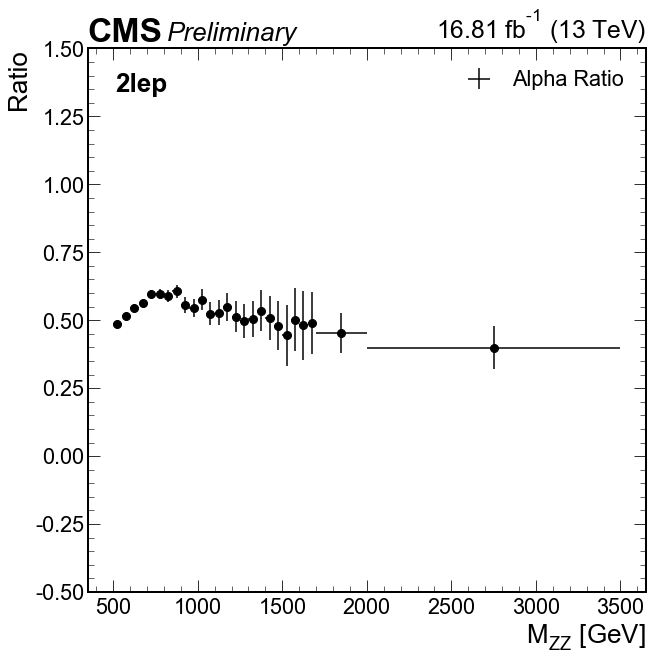

In [86]:
#produce Alpha function and store in file 
###store histo to a root file 
AlphaBranch = {}
outAlphafilepath = '/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/AlphaFile'
#outfile = uproot.recreate(f"{outAlphafilepath}/AlphaRaio_noNETsf.root")
#with uproot.recreate(f"{outAlphafilepath}/AlphaRaioVaildation.root") as outfile:
with uproot.recreate(f"{outAlphafilepath}/AlphaRaioVaildation_resolved.root") as outfile:
#outfile = uproot.recreate(f"{outAlphafilepath}/AlphaRaioVaildation.root")
    for cat in config['channel']:
        if cat =='isEE':
            text = 'twoEle'
        elif cat =='isMuMu':
            text = 'twoMuon'
        else:
            text = '2lep'

        sig_content = (bkg_hists['SR'][cat])[2].view(flow=False).value
        bkg_content = (bkg_hists['CR'][cat])[2].view(flow=False).value
        print(f"sig_content = {sig_content}")
        print(f"bkg_content = {bkg_content}")
        sig_content_err = get_err((bkg_hists['SR'][cat])[2])
        bkg_content_err = get_err((bkg_hists['CR'][cat])[2])
        alpha = sig_content/bkg_content
        alpha_err = np.sqrt(((sig_content_err/sig_content)*(sig_content_err/sig_content))+((bkg_content_err/bkg_content)*(bkg_content_err/bkg_content)))

        #print(f'Alpha function in {cat} in Merged case = {alpha}')
        print(f'Alpha function in {cat} in resolved case = {alpha}')

        #AlphaBranch[f'merged_{cat}'] = alpha
        #AlphaBranch[f'merged_{cat}_err'] = alpha_err
        AlphaBranch[f'resolved_{cat}'] = alpha
        AlphaBranch[f'resolved_{cat}_err'] = alpha_err

        x_axis = np.append(massZZ_low_bins,massZZ_high_bins)

        #width = 0.15  # the width of the bars
        x_pos = []
        y_val = []
        x_err = []
        y_err = []
        f, ax = plt.subplots(figsize=(10, 10))
        hep.cms.label(data=True, llabel='Preliminary', year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)' %config['lumi'][year], fontname='sans-serif')
        for i in range(0,len(x_axis)-1):
            x = (x_axis[i]+x_axis[i+1])/2
            x_pos.append(x)
            y = alpha[i]
            y_val.append(y)
            xerr = (x_axis[i+1]-x_axis[i])/2
            x_err.append(xerr)
            yerr = alpha_err[i]
            y_err.append(yerr)
            ax.plot(x,y,'o', markersize=8 ,color='black')
        ax.errorbar(x_pos,y_val,xerr=x_err,yerr=y_err,elinewidth = 1.5,linestyle='none',color='black',label = 'Alpha Ratio')

        ax.set_xlabel(r'$M_{ZZ}$ [GeV]', ha='right', x=1.0); ax.set_ylabel('Ratio', ha='right', y=1.0)
        ax.set_ylim(-0.5, 1.5)
        ax.text(0.05, 0.92, f'{text}', transform=ax.transAxes, fontweight='bold') 
        ax.legend(loc='upper right')
    outfile['alphatree'] = AlphaBranch

# 2.Start to Apply Alpha Function to Get The Vaildation plots

In [87]:
#Alph_path = '/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/AlphaFile/AlphaRaioVaildation.root'
Alph_path = '/cms/user/guojl/ME_test/CMSSW_10_6_26/src/HZZAnalysis/BackgroundEstimation/AlphaFile/AlphaRaioVaildation_resolved.root'
Alph_array = uproot.lazy([f"{Alph_path}:alphatree"])

In [ ]:
print(f'massZZ bins = {massZZ_bins}')
#set var draw 
varbs = ['mass2lj']
bkg_hists = {}; Data_hist = {}; signal_hists = {}
for var in varbs:
    print(f"[INFO] it is {var} plot")
    nbins, xmin, xmax = config['bininfo']['KD_ZJ'][0], config['bininfo']['KD_ZJ'][1], config['bininfo']['KD_ZJ'][2]
    #edge = np.linspace(xmin, xmax, nbins+1)
    if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
        islogY = True
    else:
        islogY = True

    #fill histo 
    #bkg_hists = {}; Data_hist = {}; signal_hists = {}
    for reg in regions:
        bkg_hists[reg] = {}; Data_hist[reg] = {}; signal_hists[reg] = {}
        for cat in config['channel']:
            bkg_hists[reg][cat] = [None,None,None,None]; Data_hist[reg][cat] = None; signal_hists[reg][cat] = []
            for sample in config['Samples_lists']:
                print(f"This is {sample} in {cat}")
                if sample!='Data':
                    temp_array = bkg_array[reg][cat][sample]
                    #retray weight and apply paritcleNet weight
                    weights = (temp_array['EventWeight']*config['lumi'][year]*1000*config['samples_inf'][sample][1])/sumWeight[sample]
                    
                    if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                        sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)   
                    #elif sample.find('DY')!=-1:
                    #    sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
                    #elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                    #    sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
                    else:
                        sf_Net = ak.ones_like(temp_array['EventWeight'])
                    weights = weights*sf_Net
                    

                    #temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                    temp_hist = bh.Histogram(massZZ_bins,storage=bh.storage.Weight())
                    temp_hist.fill(temp_array[var],weight = weights)

                    print("[INFO] stroe kd")
                    hist_KD = get_hist(temp_array['KD_ZJ'],weights,nbins,xmin,xmax)
                    hist_KD.fill(temp_array['KD_ZJ'],weight = weights)
                    


                    if sample.find('DY')!=-1:
                        print("[INFO] KD_array = ",temp_array['KD_ZJ'])
                        print("[INFO] hist_KD = ",hist_KD.view(flow=False).value)
                        if (bkg_hists[reg][cat])[3]==None:
                            #(bkg_hists[reg][cat])[3] = temp_hist
                            (bkg_hists[reg][cat])[3] = hist_KD
                        else:
                            #(bkg_hists[reg][cat])[3]+=temp_hist
                            (bkg_hists[reg][cat])[3]+=hist_KD
                    if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                        if (bkg_hists[reg][cat])[1]==None:
                            (bkg_hists[reg][cat])[1] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[1]+=temp_hist
                    if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                        if (bkg_hists[reg][cat])[0]==None:
                            (bkg_hists[reg][cat])[0] = temp_hist
                        else:
                            (bkg_hists[reg][cat])[0]+=temp_hist
                else:
                    temp_array = data_array[reg][cat]
                    weights = np.ones_like(temp_array['EventWeight'])
                    print(f'data weight  = {weights}')
                    #Data_hist[reg][cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                    Data_hist[reg][cat] = bh.Histogram(massZZ_bins,storage=bh.storage.Weight())
                    Data_hist[reg][cat].fill(temp_array[var],weight=weights)
                    #Data_hist[reg][cat] = temp_hist

            for sample in config['signal_lists']:
                temp_array = signal_array[reg][cat][sample]
                weights = (temp_array['EventWeight']*config['lumi']['2016']*config['samples_inf'][sample][1]*10)/sumWeight[sample] #scale 10
                #sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
                #weights = weights*sf_Net
                #temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                temp_hist = bh.Histogram(massZZ_bins,storage=bh.storage.Weight())
                temp_hist.fill(temp_array[var],weight = weights)
                signal_hists[reg][cat].append(temp_hist)

massZZ bins = Variable(array([ 500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000., 1050., 1100., 1150., 1200., 1250., 1300., 1350.,
       1400., 1450., 1500., 1550., 1600., 1650., 1700., 2000., 3500.]))
[INFO] it is mass2l2jet plot
This is DY_pt50To100 in 2lep
This is DY_pt100To250 in 2lep
This is DY_pt250To400 in 2lep
This is DY_pt400To650 in 2lep
This is DY_pt650ToInf in 2lep
This is TTJets in 2lep
This is WZTo2Q2L in 2lep
This sf_array =  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ... 0, 0, 1.11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ZZTo2Q2L in 2lep
This sf_array =  [0, 0, 0, 0, 0, 0, 0, 1.04, 0, 0, 0, 0, ... 0, 0.985, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
This is WWTo2L2Nu in 2lep
This is Data in 2lep
data weight  = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fill done
[INFO] start to stroe 2D
[INFO] stroe 2D done


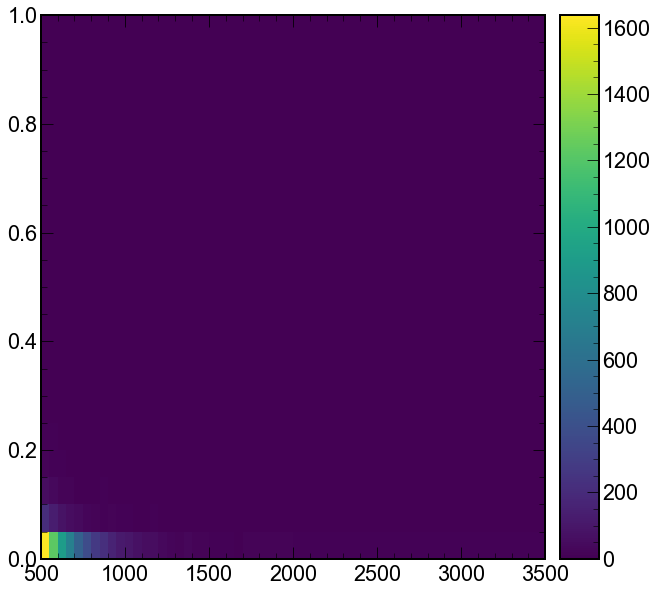

In [90]:
#with uproot.recreate('template_merged_Zjet.root') as outfile:
with uproot.recreate('template_resolved_Zjet.root') as outfile:
    regions = ['CR']
    print(f'massZZ bins = {massZZ_bins}')
    #set var draw 
    #varbs = ['mass2lj']
    varbs = ['mass2l2jet']
    bkg_hists = {}; Data_hist = {}; signal_hists = {}
    bkg_arr = {}; Data_arr = {}; weight_arr={}

    for var in varbs:
        print(f"[INFO] it is {var} plot")
        #nbins, xmin, xmax = config['bininfo']['KD_ZJ'][0], config['bininfo']['KD_ZJ'][1], config['bininfo']['KD_ZJ'][2]
        nbins, xmin, xmax = config['bininfo']['KD_Zjj'][0], config['bininfo']['KD_Zjj'][1], config['bininfo']['KD_Zjj'][2]
        #edge = np.linspace(xmin, xmax, nbins+1)
        if var.find('pt')!=-1 or var.find('massmerged')!=-1 or var.find('mass2jet')!=-1:
            islogY = True
        else:
            islogY = True

        #fill histo 
        #bkg_hists = {}; Data_hist = {}; signal_hists = {}
        for reg in regions:
            bkg_hists[reg] = {}; Data_hist[reg] = {}; signal_hists[reg] = {}
            bkg_arr[reg] = {}; Data_arr[reg] = {}; weight_arr[reg]={}
            for cat in config['channel']:
                bkg_hists[reg][cat] = [None,None,None,None]; Data_hist[reg][cat] = None; signal_hists[reg][cat] = []
                bkg_arr[reg][cat] = [None,None,None,None]; Data_arr[reg][cat] = None; weight_arr[reg][cat] = {}
                for sample in config['Samples_lists']:
                    print(f"This is {sample} in {cat}")
                    if sample!='Data':
                        if sample.find('DY')!=-1: continue
                        temp_array = bkg_array[reg][cat][sample]
                        #retray weight and apply paritcleNet weight
                        weights = (temp_array['EventWeight']*config['lumi'][year]*1000*config['samples_inf'][sample][1])/sumWeight[sample]

                        if sample == 'ZZTo2Q2L' or sample =='WZTo2Q2L':
                            sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)   
                        #elif sample.find('DY')!=-1:
                        #    sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','DY')
                        #elif sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                        #    sf_Net = GetParticleNetbkgSF(temp_array,'ZvsQCD','TT')
                        else:
                            sf_Net = ak.ones_like(temp_array['EventWeight'])
                        weights = weights*sf_Net


                        #temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                        temp_hist = bh.Histogram(massZZ_bins,bh.axis.Regular(20, 0, 1),storage=bh.storage.Weight())
                        temp_hist.fill(temp_array[var],temp_array['KD_Zjj'],weight = weights)

                        #print("[INFO] stroe kd")
                        #hist_KD = get_hist(temp_array['KD_ZJ'],weights,nbins,xmin,xmax)
                        #hist_KD.fill(temp_array['KD_ZJ'],weight = weights)



                        #if sample.find('DY')!=-1:
                        #    print("[INFO] KD_array = ",temp_array['KD_ZJ'])
                        #    print("[INFO] hist_KD = ",hist_KD.view(flow=False).value)
                        #    if (bkg_hists[reg][cat])[3]==None:
                        #        #(bkg_hists[reg][cat])[3] = temp_hist
                        #        (bkg_hists[reg][cat])[3] = hist_KD
                        #    else:
                        #        #(bkg_hists[reg][cat])[3]+=temp_hist
                        #        (bkg_hists[reg][cat])[3]+=hist_KD
                        if sample.find('TTJets')!=-1 or sample.find('WWTo2L2Nu')!=-1:
                            if (bkg_hists[reg][cat])[1]==None:
                                (bkg_hists[reg][cat])[1] = temp_hist
                            else:
                                (bkg_hists[reg][cat])[1]+=temp_hist
                        if sample.find('WZTo2Q2L')!=-1 or sample.find('ZZTo2Q2L')!=-1:
                            if (bkg_hists[reg][cat])[0]==None:
                                (bkg_hists[reg][cat])[0] = temp_hist
                            else:
                                (bkg_hists[reg][cat])[0]+=temp_hist
                    else:
                        temp_array = data_array[reg][cat]
                        weights = np.ones_like(temp_array['EventWeight'])
                        print(f'data weight  = {weights}')
                        #Data_hist[reg][cat] = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                        Data_hist[reg][cat] = bh.Histogram(massZZ_bins,bh.axis.Regular(20, 0, 1),storage=bh.storage.Weight())
                        Data_hist[reg][cat].fill(temp_array[var],temp_array['KD_Zjj'],weight=weights)
                        #Data_hist[reg][cat] = temp_hist

                #for sample in config['signal_lists']:
                #    temp_array = signal_array[reg][cat][sample]
                #    weights = (temp_array['EventWeight']*config['lumi']['2016']*config['samples_inf'][sample][1]*10)/sumWeight[sample] #scale 10
                #    #sf_Net = GetParticleNetSignalSF(temp_array,'ZvsQCD',sf_particleNet_signal)
                #    #weights = weights*sf_Net
                #    #temp_hist = get_hist(temp_array[var],weights,nbins,xmin,xmax)
                #    temp_hist = bh.Histogram(massZZ_bins,storage=bh.storage.Weight())
                #    temp_hist.fill(temp_array[var],weight = weights)
                #    signal_hists[reg][cat].append(temp_hist)

    print("Fill done")
    #store 2D template
    print("[INFO] start to stroe 2D")
    Data_hist['CR']['2lep'].view(flow=False).value = Data_hist['CR']['2lep'].view(flow=False).value - (bkg_hists['CR']['2lep'])[0].view(flow=False).value- (bkg_hists['CR']['2lep'])[1].view(flow=False).value
    #Data_hist['CR']['2lep'].view(flow=False).value[:,0] = Data_hist['CR']['2lep'].view(flow=False).value[:,0]*Alph_array[f'merged_{cat}']
    Data_hist['CR']['2lep'].view(flow=False).value[:,0] = Data_hist['CR']['2lep'].view(flow=False).value[:,0]*Alph_array[f'resolved_{cat}']
    #content_data = Data_hist['CR']['2lep'].view(flow=False).value
    #content_TT = (bkg_hists['CR']['2lep'])[0].view(flow=False).value
    #content_ZV = (bkg_hists['CR']['2lep'])[1].view(flow=False).value
    #content_DY = content_data - content_TT - content_ZV
    #content_DY[:,0] = content_DY[:,0]*Alph_array[f'merged_{cat}']
    #SR_DY = bh.Histogram(massZZ_bins,bh.axis.Regular(20, 0, 1))
    #SR_DY.fill(content_DY)

    hep.hist2dplot(Data_hist['CR']['2lep'])
    #plt.close()

    #outfile['DY_merged'] = Data_hist['CR']['2lep']
    #outfile['DY_merged_up'] = Data_hist['CR']['2lep']
    #outfile['DY_merged_down'] = Data_hist['CR']['2lep']
    outfile['DY_resolved'] = Data_hist['CR']['2lep']
    outfile['DY_resolved_up'] = Data_hist['CR']['2lep']
    outfile['DY_resolved_down'] = Data_hist['CR']['2lep']
    print("[INFO] stroe 2D done")

    

In [76]:
Data_hist['CR']['2lep'].view(flow=False).value[:,0]

array([110.,  78.,  80.,  54.,  44.,  33.,  41.,  25.,  20.,  13.,  15.,
         5.,   6.,  10.,   5.,   2.,   1.,   4.,   2.,   4.,   2.,   2.,
         2.,   1.,   6.,   1.])

In [77]:
 Data_hist['CR']['2lep'].view(flow=False).value = Data_hist['CR']['2lep'].view(flow=False).value - (bkg_hists['CR']['2lep'])[0].view(flow=False).value- (bkg_hists['CR']['2lep'])[1].view(flow=False).value


In [78]:
 Data_hist['CR']['2lep'].view(flow=False).value[:,0]

array([99.61328749, 70.30920173, 75.36614313, 49.93049381, 42.13868974,
       29.87356584, 37.6879127 , 24.06897371, 19.93157765, 12.2460785 ,
       14.71158262,  4.39701039,  4.83271254,  9.42185558,  4.8564734 ,
        1.47573349, -0.40897316,  4.28582857,  1.8526408 ,  3.99516205,
        1.62254587,  1.98865037,  1.98278883,  0.97597906,  5.48512206,
        0.90515165])

In [38]:
#reduce TT ZV and WW from Data Sideband
#H_Data_SB = Data_hist['CR']['isEE'] - (bkg_hists['CR']['isEE'])[1] - (bkg_hists['CR']['isEE'])[0]
with uproot.recreate("template_merged_Zjet.root") as outfile:
    for cat in config['channel']:
        if cat =='isEE':
            text = 'twoEle'
        elif cat =='isMuMu':
            text = 'twoMuon'
        else:
            text = '2lep'

        print(f"This is {cat}")
        TT_content = (bkg_hists['CR'][cat])[1].view(flow=False).value
        ZV_content = (bkg_hists['CR'][cat])[0].view(flow=False).value
        Data_content = Data_hist['CR'][cat].view(flow=False).value

        Data_SB = (Data_content - ZV_content)- TT_content

        SR_DY = Data_SB*Alph_array[f'merged_{cat}']

        (bkg_hists['SR'][cat])[2] = bh.Histogram(massZZ_bins)

        ((bkg_hists['SR'][cat])[2])[:] = SR_DY

        hist2D = bh.Histogram(massZZ_bins,bh.axis.Regular(20, 0, 1))
        hist2D = np.array(SR_DY,(bkg_hists['SR']['2lep'])[3].view(flow=False).value)
        #hist2D[0,:] = (bkg_hists['SR']['2lep'])[3].view(flow=False).value
        #hist2D[:,0] = SR_DY

        outfile['DY_merged'] = hist2D
        outfile['DY_merged_up'] = hist2D
        outfile['DY_merged_donw'] = hist2D

        print("[INFO] stroe done")

        #set_sns_color(color_order_bkg)
        #edge = np.append(massZZ_low_bins,massZZ_high_bins)
        #f = plt.figure(figsize=(12,12))
        #gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1], hspace=0)
        #ax = f.add_subplot(gs[0])
        #hep.cms.label(data=True, llabel='Preliminary', year='2016', ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)' %config['lumi'][year], fontname='sans-serif')
        ##hep.cms.label(data=True, year=year, ax=ax, rlabel=r'%s $fb^{-1}$ (13 TeV)'%lumi[year], fontname='sans-serif')
#
        #hep.histplot(bkg_hists['SR'][cat],label=[f'MC ({var})' for var in ['WZ,ZZ','TT,WW','Z+jets']],histtype='fill', edgecolor='k', linewidth=1, stack=True) ## draw MC
        #ax.set_xlabel(r'$M_{ZZ}$ [GeV]', ha='right', x=1.0)
        #ax.set_ylabel('Events / bin', ha='right', y=1.0);
#
        ###SIGNAL
        #colors = ['blue', 'red']
        #hep.histplot(signal_hists['SR'][cat],label=[ var for var in ['ggH(m1000)x10','VBF(m1500)x10']],linestyle=[style for style in [':','--']], color=[color for color in colors])
#
        ###DATA
        #data_err = get_err(Data_hist['SR'][cat])
        #data = Data_hist['SR'][cat].values()
        ##hep.histplot(Data_hist[cat], yerr=data_err,label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
        #plot_hist(Data_hist['SR'][cat],label='Data', histtype='errorbar', color='k', markersize=15, elinewidth=1.5) ## draw data
#
        ##bkg_hist = bkg_hists['SR']['isEE'][0]+bkg_hists['SR']['isEE'][1]+bkg_hists['SR']['isEE'][2]
        #bkg_tot = bkg_hists['SR'][cat][0].values()+bkg_hists['SR'][cat][1].values()+bkg_hists['SR'][cat][2].values()
        #bkg_err = np.sqrt(bkg_tot)
        #print(f'bkg_err in {cat} = {bkg_err}')
        #ax.fill_between(edge, (bkg_tot-bkg_err).tolist()+[0], (bkg_tot+bkg_err).tolist()+[0], label='BKG total unce.', step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        #ax.fill_between(edge, (bkg_tot-bkg_err-Alph_array[f'merged_{cat}_err']).tolist()+[0], (bkg_tot-bkg_err).tolist()+[0], label='Alpha total unce.', step='post', hatch='xx', edgecolor='darkgrey', facecolor='none', linewidth=0) ## draw bkg unce.
        #ax.fill_between(edge, (bkg_tot+bkg_err).tolist()+[0], (bkg_tot+bkg_err+Alph_array[f'merged_{cat}_err']).tolist()+[0],step='post', hatch='xx', edgecolor='darkgrey', facecolor='none', linewidth=0) ## draw bkg unce.
#
#
        #ax.set(yscale = "log")
        #ax.set_ylim(1e-1, 3*ax.get_ylim()[1])
        #ax.text(0.05, 0.92, f'{text}', transform=ax.transAxes, fontweight='bold') 
        #ax.legend(fontsize=18)
        ###==========================================Ratio panel========================
        #ax1 = f.add_subplot(gs[1]); ax1.set_xlim(xmin, xmax); ax1.set_ylim(0.001, 1.999)
        #ax1.set_xlabel(config['bininfo'][var][3], ha='right', x=1.0); ax1.set_ylabel('Data / MC', ha='center')
        #ax1.plot([xmin,xmax], [1,1], 'k'); ax1.plot([xmin,xmax], [0.5,0.5], 'k:'); ax1.plot([xmin,xmax], [1.5,1.5], 'k:')
#
        #ratio=np.nan_to_num((data/bkg_tot),nan=-1)
        #ratio_err = np.nan_to_num((data_err/bkg_tot),nan=-1)
        #hep.histplot(ratio, yerr = ratio_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
        ##hep.histplot(data/bkg_tot, yerr = data_err/bkg_err,bins=edge, histtype='errorbar', color='k', markersize=15, elinewidth=1)
        ##if plot_unce:
        #ratio_unc_low = np.nan_to_num(((bkg_tot-bkg_err)/bkg_tot),nan=-1)
        #ratio_unc_up = np.nan_to_num(((bkg_tot+bkg_err)/bkg_tot),nan=-1)
        #ax1.fill_between(edge, ratio_unc_low.tolist()+[0],ratio_unc_up.tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.
        ##ax1.fill_between(edge, ((bkg_tot-bkg_err)/bkg_tot).tolist()+[0], ((bkg_tot+bkg_err)/bkg_tot).tolist()+[0], step='post', hatch='\\\\', edgecolor='darkblue', facecolor='none', linewidth=0) ## draw bkg unce.

This is 2lep


ValueError: cannot broadcast RegularArray of size 20 with RegularArray of size 26

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/awkward/_util.py#L914)

In [85]:
hist2D = bh.Histogram(massZZ_bins,bh.axis.Regular(20, 0, 1))

In [87]:
hist2D.fill(1,2,weight =1)

Histogram(
  Variable(array([ 500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,  900.,
        950., 1000., 1050., 1100., 1150., 1200., 1250., 1300., 1350.,
       1400., 1450., 1500., 1550., 1600., 1650., 1700., 2000., 3500.])),
  Regular(20, 0, 1),
  storage=Double()) # Sum: 0.0 (1.0 with flow)

In [46]:
(bkg_hists['SR']['2lep'])[3].view(flow=False).value

array([70.21362863, 82.63412566, 85.2713908 , 85.46517519, 66.19560302,
       67.05284223, 58.33868199, 51.26323717, 47.72209999, 40.14754439,
       39.71792572, 41.90558412, 38.94285579, 33.93679384, 36.08582487,
       36.4113139 , 39.29806949, 44.90038964, 58.89604066, 72.76204162])

In [82]:
hist2D = SR_DY

In [71]:
hist2D[:,0] = SR_DY

In [73]:
hist2D[0,:] = (bkg_hists['SR']['2lep'])[3].view(flow=False).value

In [84]:
hist2D[0,:]

ValueError: in NumpyArray, too many dimensions in slice

(https://github.com/scikit-hep/awkward-1.0/blob/1.8.0/src/libawkward/array/NumpyArray.cpp#L4153)